In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

from unsloth import FastLanguageModel
import torch

from multiprocessing import cpu_count
num_proc = cpu_count()

import yaml

from data_processor import SplittedJsonIoDataset
from customs import customize_tokenizer

from unsloth import UnslothTrainer, UnslothTrainingArguments

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import TrainingArguments, DataCollatorForSeq2Seq, DataCollatorForLanguageModeling
from unsloth import is_bfloat16_supported

from unsloth.chat_templates import train_on_responses_only

from unsloth import unsloth_train

from utils import save_log_history

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 07-07 13:18:58 [__init__.py:244] Automatically detected platform cuda.


In [2]:
# Clear GPU cache
torch.cuda.empty_cache()

In [3]:
with open("config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

model, tokenizer = FastLanguageModel.from_pretrained(
    **config["model_loading_args"]
)

model, tokenizer = customize_tokenizer(model, tokenizer, config)

==((====))==  Unsloth 2025.6.8: Fast Llama patching. Transformers: 4.53.0. vLLM: 0.9.1.
   \\   /|    NVIDIA H100 PCIe. Num GPUs = 1. Max memory: 79.19 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Tokenizer has a built-in chat template.
It follows an xample of a formatted instruction using chat template. If instruction_part and           response_part have been defined in config.yaml, please verify their correctness.
           CHAT TEMPLATE
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>assistant<|end_header_id|>

SYSTEM MESSAGE PLACEHOLDER<|eot_id|><|start_header_id|>user<|end_header_id|>

USER INPUT MESSAGE PLACEHOLDER<|eot_id|><|start_header_id|>assistant<|end_header_id|>

MODEL RESPONSE MESSAGE PLACEHOLDER<|eot_id|>
Pad token is already set to: <|finetune_right_pad_id|>
Default padding side is left. It is forced to be on the right!


In [4]:
print(f"Model's context window: {model.max_seq_length}")

Model's context window: 131072


In [5]:
# Create dataset for training
dataset = SplittedJsonIoDataset(tokenizer, config).create()

Filter:   0%|          | 0/1564 [00:00<?, ? examples/s]

Filter:   0%|          | 0/207 [00:00<?, ? examples/s]

In [6]:
# Add LoRA weights
model = FastLanguageModel.get_peft_model(
    model=model,
    **config["lora_parameters"]
)

Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.6.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM


In [7]:
# Select data collator
if config["fine_tuning_args"]["training_type"]=="text_completion":
    _train_on_responses_only_bool = True
    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)
elif config["fine_tuning_args"]["training_type"]=="continued_pre_training":
    _train_on_responses_only_bool = False
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
else:
    raise Exception("Wrong Training Type. Check config.yaml")

In [8]:
# Initiate trainer
trainer = UnslothTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["eval"],
    data_collator = data_collator,
    dataset_text_field = "text",
    max_seq_length = config["model_loading_args"]["max_seq_length"], # Used only when packing=True for creating a ConstantLengthDataset.
    packing = config["sft_trainer_arguments"]["apply_packing"],
    dataset_num_proc = num_proc,
    args = UnslothTrainingArguments(
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        **config["training_arguments"]
    )
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/1547 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/206 [00:00<?, ? examples/s]

In [9]:
# Wrap trainer for apply training using only the assistant part
if _train_on_responses_only_bool:
    trainer = train_on_responses_only(
        trainer,
        instruction_part = config["instruction_part"],
        response_part = config["response_part"]
    )

Map (num_proc=30):   0%|          | 0/1547 [00:00<?, ? examples/s]

Map (num_proc=30):   0%|          | 0/206 [00:00<?, ? examples/s]

In [10]:
# Start training
trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,547 | Num Epochs = 2 | Total steps = 194
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 546,308,096/8,576,569,344 (6.37% trained)


Unsloth: Setting lr = 5.00e-06 instead of 5.00e-05 for lm_head.
Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
1,0.771000,0.356180
2,1.115600,0.356095
3,0.960200,0.356047
4,0.163300,0.355053
5,0.619800,0.354366
6,0.526900,0.352293
7,0.635200,0.348407
8,0.817000,0.343291
9,0.343800,0.336320
10,1.079100,0.327256


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


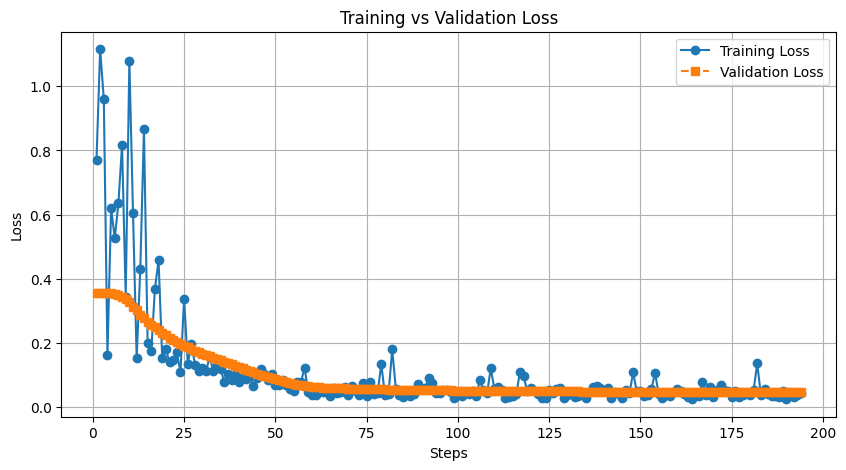

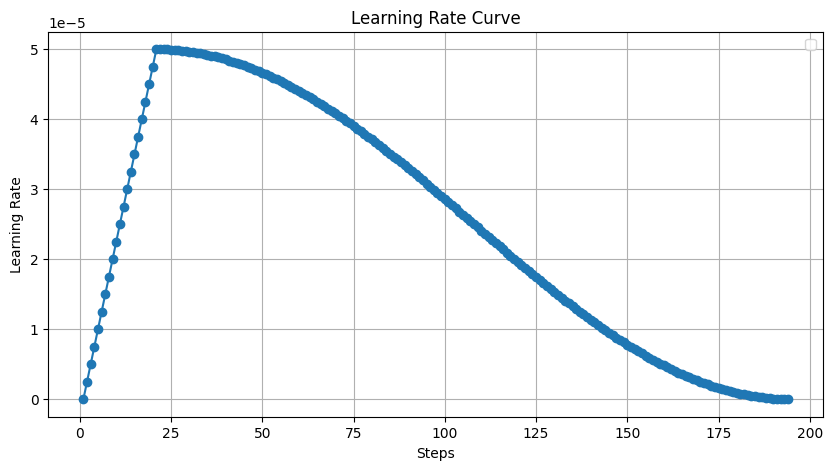

In [11]:
save_log_history(trainer)

In [16]:
!sudo mkdir /mnt/data/training-outputs/Llama
!sudo cp -r Llama-3.1-8B-Instruct-Not-Quantized /mnt/data/training-outputs/Llama
!sudo cp -r log_history /mnt/data/training-outputs/Llama
!ls /mnt/data/training-outputs/Llama

Llama-3.1-8B-Instruct-Not-Quantized  log_history


In [13]:
from transformers import TextStreamer

FastLanguageModel.for_inference(model)
text_streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

def format_input_prompt(system_message, user_input):
    formatted_input = [
        {"role": "assistant", "content": system_message},
        {"role": "user", "content": user_input}
    ]
    return formatted_input

def format_validation_example_for_inference(example):
    return example.split("<|start_header_id|>user<|end_header_id|>")[1].split("<|eot_id|><|start_header_id|>assistant<|end_header_id|>")[0]

def inference(model, system_message, user_input, max_new_tokens=None, **kwargs):
    input_ids = tokenizer.apply_chat_template(
        format_input_prompt(system_message, user_input),
        add_generation_prompt=True,
        return_tensors = "pt").to("cuda")
    if not max_new_tokens:
        max_new_tokens = model.config.max_position_embeddings - input_ids.shape[-1]
    model.generate(input_ids, streamer = text_streamer, max_new_tokens=max_new_tokens, **kwargs)

In [14]:
system_message = ""
user_input = "Hello! How are you?"
inference(model, system_message, user_input, max_new_tokens=100)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
LlamaForCausalLM has no `_prepare_4d_causal_attention_mask_with_cache_position` method defined in its base modeling class. Compiled forward passes will be sub-optimal. If you're writing code, see Llama for an example implementation. If you're a user, please report this issue on GitHub.


I'm functioning properly. Thank you for asking. How can I assist you today?


In [15]:
system_message = config["system_message"]
user_input = format_validation_example_for_inference(dataset["eval"]["text"][134])
inference(model,
          system_message, 
          user_input, 
          max_new_tokens=None,
          temperature=0.7,
          top_p=0.6,
          repetition_penalty=1.1,
          no_repeat_ngram_size=3,
          do_sample=True)

{"id": "", "type": "bundle", "objects": [{"id": "report--Large-Scaled Strelastealeer Campaign in early 202", "type': report', "name': 'Large-Saled Strelastaealeer Campign in early ', "description': 'Strelasteaeler malware steals emai llogin dat from welknown email clients snd sends them beck to the attcker''s C2 sever.', "labels': ['jscript', strelasteeler', 'credential stealer', malspem'], "report_types': ['threat-report'], "created': '2024-03-22 10::36:13.840000+00:00', "object_refs': ["report--Lareg-Saled Sterlaestealeer Camign in eariy ", "indicator--f95c68t17086dc49h648509tbf370cse3fc306a537t8d51tfd1t5619bt30f33ae", "indicator---ea99899e70fafa6btd9ce500dd3tfb7aa6a577b74t01e9tb240443sa8777bee054", "file--f96c68i17086dcd49h684509tbd370c3fc304a53778d519td1t5659bt3013ae", 'indicator--0d250588a3aat7cff336206be3dt75401te6c696bff30aa159d334ce58dsf799ae', 'indicator---aee9989ee70faffab1d99ce500d3afb7ta6a575b74o1ebeb240443a87777be054', malware--Strelstealer', "attack-pattern--T1027", "atta